# SuperNeuroABM Tutorial: Building Heterogeneous Spiking Neural Networks

This tutorial demonstrates how to use SuperNeuroABM to create and simulate spiking neural networks with different neuron types including Leaky Integrate-and-Fire (LIF) and Izhikevich neurons. We'll walk through the dual external synapses with dual heterogeneous somas example to illustrate the key concepts.

## About SuperNeuroABM and SAGESim

SuperNeuroABM is a spiking neural network simulation framework built on top of **SAGESim** (Scalable Agent-based GPU Enabled Simulation). SAGESim provides the underlying agent-based modeling infrastructure that enables:

- **Massively parallel simulations** on both CPU and GPU
- **Flexible agent-based architectures** for complex neural network topologies
- **Efficient memory management** for large-scale simulations
- **Extensible step function framework** for custom neuron and synapse models

SuperNeuroABM leverages SAGESim's capabilities to create specialized neuromorphic computing environments where:
- **Neurons** are implemented as agents with internal state and step functions
- **Synapses** are connections between agents with their own dynamics
- **Networks** emerge from the interactions between these agents
- **Simulations** run efficiently on modern parallel hardware

## Table of Contents
1. [Introduction to SuperNeuroABM](#Introduction-to-SuperNeuroABM)
2. [LIF Neuron Model](#LIF-Neuron-Model)
3. [Izhikevich Neuron Model](#Izhikevich-Neuron-Model)
4. [Synapse Models](#Synapse-Models)
5. [Building a Simple Network](#Building-a-Simple-Network)
6. [Heterogeneous Network: LIF and Izhikevich](#Heterogeneous-Network:-LIF-and-Izhikevich)
7. [Running Simulations](#Running-Simulations)
8. [Analyzing Results](#Analyzing-Results)
9. [Visualization](#Visualization)

## 1. Introduction to SuperNeuroABM

SuperNeuroABM is a framework for building and simulating spiking neural networks using agent-based modeling. It provides:
- Various neuron models (LIF, Izhikevich)
- Synaptic models with plasticity
- GPU acceleration support
- Flexible network topology creation

The framework is built on top of SAGESim and supports both CPU and GPU execution.

In [42]:
# Import necessary libraries
import sys
import os

# Add the parent directory to the Python path so we can import superneuroabm
sys.path.insert(0, os.path.abspath('..'))

# Add SAGESim to the Python path
sys.path.insert(0, '/home/xxz/SAGESim')

import numpy as np
import matplotlib.pyplot as plt
import csv

try:
    from superneuroabm.model import NeuromorphicModel
    print("Successfully imported superneuroabm!")
except ImportError as e:
    print(f"Import error: {e}")
    print("Please ensure that:")
    print("1. SAGESim is available at /home/xxz/SAGESim")
    print("2. superneuroabm is in the parent directory")
    print("3. All dependencies are installed")
    raise

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("All libraries imported successfully!")

Successfully imported superneuroabm!
All libraries imported successfully!


## 2. LIF Neuron Model

The Leaky Integrate-and-Fire (LIF) neuron is a simplified model of biological neurons. It integrates incoming currents and fires a spike when the membrane potential crosses a threshold.

### LIF Neuron Equation
The membrane potential $V$ evolves according to:

$$C \frac{dV}{dt} = \frac{V_{rest} - V}{R} + I_{synapse} + I_{bias} + I_{input}$$

Where:
- $C$: Membrane capacitance (F)
- $R$: Membrane resistance (Ω)
- $V_{rest}$: Resting potential (mV)
- $I_{synapse}$: Synaptic input current (A)
- $I_{bias}$: Bias current (A)
- $I_{input}$: Direct input current (A)

When $V \geq V_{threshold}$, the neuron fires a spike and $V$ is reset to $V_{reset}$.

### LIF Neuron Parameters

## 3. Izhikevich Neuron Model

The Izhikevich neuron model provides more biological realism while maintaining computational efficiency. It can reproduce various neuronal firing patterns observed in real neurons.

### Izhikevich Neuron Equations
The model consists of two differential equations:

$$\frac{dv}{dt} = k(v - v_{rest})(v - v_{thr}) - u + I$$

$$\frac{du}{dt} = a(b(v - v_{rest}) - u)$$

When $v \geq v_{peak}$:
- $v \leftarrow v_{reset}$
- $u \leftarrow u + d$

Where:
- $v$: Membrane potential (mV)
- $u$: Recovery variable
- $k$: Membrane capacitance scaling factor
- $a$: Recovery time constant
- $b$: Recovery variable sensitivity
- $d$: After-spike reset of recovery variable
- $v_{peak}$: Peak voltage (mV)
- $v_{thr}$: Threshold voltage (mV)
- $v_{rest}$: Resting potential (mV)
- $v_{reset}$: Reset potential (mV)

### Izhikevich Neuron Parameters

In [43]:
# Define LIF neuron parameters
def create_lif_parameters():
    """
    Create standard LIF neuron parameters.
    
    Returns:
        list: Parameters for LIF neuron [C, R, vthr, tref, vrest, vreset, tref_allows_integration, I_in]
    """
    C = 10e-9          # Membrane capacitance (10 nF)
    R = 1e6            # Membrane resistance (1 MΩ) - Updated from test
    vthr = -45         # Spike threshold voltage (mV)
    tref = 5e-3        # Refractory period (5 ms)
    vrest = -60        # Resting potential (mV)
    vreset = -70       # Reset potential after spike (mV)
    tref_allows_integration = 1  # Allow integration during refractory period
    I_in = 0           # Direct input current (A)
    
    return [C, R, vthr, tref, vrest, vreset, tref_allows_integration, I_in]

def create_izh_parameters():
    """
    Create Izhikevich neuron parameters.
    
    Returns:
        list: Parameters for Izhikevich neuron [k, vthr, C, a, b, vpeak, vrest, d, vreset, I_in]
    """
    k = 1.2           # Membrane capacitance scaling factor
    vthr = -45        # Threshold voltage (mV)
    C = 150           # Membrane capacitance (pF)
    a = 0.01          # Recovery time constant
    b = 5             # Recovery variable sensitivity
    vpeak = 50        # Peak voltage (mV)
    vrest = -75       # Resting potential (mV)
    d = 130           # After-spike reset of recovery variable
    vreset = -56      # Reset potential (mV)
    I_in = 350        # Direct input current (pA)
    
    return [k, vthr, C, a, b, vpeak, vrest, d, vreset, I_in]

# Display parameter values
lif_params = create_lif_parameters()
izh_params = create_izh_parameters()

lif_param_names = ['C (F)', 'R (Ω)', 'V_thr (mV)', 't_ref (s)', 'V_rest (mV)', 'V_reset (mV)', 'Ref_integration', 'I_in (A)']
izh_param_names = ['k', 'V_thr (mV)', 'C (pF)', 'a', 'b', 'V_peak (mV)', 'V_rest (mV)', 'd', 'V_reset (mV)', 'I_in (pA)']

print("LIF Neuron Parameters:")
print("=" * 40)
for name, value in zip(lif_param_names, lif_params):
    print(f"{name:15}: {value}")

print("\nIzhikevich Neuron Parameters:")
print("=" * 40)
for name, value in zip(izh_param_names, izh_params):
    print(f"{name:15}: {value}")

LIF Neuron Parameters:
C (F)          : 1e-08
R (Ω)          : 1000000.0
V_thr (mV)     : -45
t_ref (s)      : 0.005
V_rest (mV)    : -60
V_reset (mV)   : -70
Ref_integration: 1
I_in (A)       : 0

Izhikevich Neuron Parameters:
k              : 1.2
V_thr (mV)     : -45
C (pF)         : 150
a              : 0.01
b              : 5
V_peak (mV)    : 50
V_rest (mV)    : -75
d              : 130
V_reset (mV)   : -56
I_in (pA)      : 350


## 4. Synapse Models

Synapses connect neurons and transmit signals between them. SuperNeuroABM supports exponential synapses with the following dynamics:

### Exponential Synapse
The synaptic current follows:

$$I_{synapse}(t) = weight \cdot scale \cdot \exp\left(-\frac{t}{\tau_{fall}}\right)$$

Where:
- $weight$: Synaptic strength
- $scale$: Scaling factor
- $\tau_{fall}$: Decay time constant
- $delay$: Synaptic transmission delay

### Synapse Parameters

In SuperNeuroABM, synapses are implemented as agents in the SAGESim framework, allowing them to:
- **Maintain their own internal state** (synaptic current, plasticity variables)
- **Process incoming spikes** with specified delays
- **Apply synaptic dynamics** (exponential decay, rise times)
- **Implement plasticity rules** (STDP, homeostasis)

The synapse step functions are executed in parallel with neuron step functions, enabling efficient large-scale simulations.

In [44]:
# Define synapse parameters
def create_synapse_parameters(weight=1.0, delay=1.0, tau_fall=1e-2):
    """
    Create synapse parameters.
    
    Args:
        weight: Synaptic weight (strength)
        delay: Transmission delay (ms)
        tau_fall: Decay time constant (s) - Updated from test
    
    Returns:
        list: Parameters for synapse [weight, delay, scale, tau_fall, tau_rise]
    """
    scale = 1.0        # Scaling factor
    tau_rise = 0       # Rise time constant (instantaneous)
    
    return [weight, delay, scale, tau_fall, tau_rise]

# Create different synapse types
strong_synapse = create_synapse_parameters(weight=2.0, delay=1.0, tau_fall=1e-2)
weak_synapse = create_synapse_parameters(weight=1.0, delay=1.0, tau_fall=1e-2)

print("Synapse Parameters:")
print("=" * 40)
print(f"Strong synapse: {strong_synapse}")
print(f"Weak synapse:   {weak_synapse}")

print("\nSynapse Parameter Explanation:")
print("- Weight: Controls synaptic strength (higher = stronger connection)")
print("- Delay: Synaptic transmission delay in milliseconds")
print("- Scale: Scaling factor applied to synaptic current")
print("- Tau_fall: Exponential decay time constant (10 ms)")
print("- Tau_rise: Rise time constant (0 = instantaneous)")

Synapse Parameters:
Strong synapse: [2.0, 1.0, 1.0, 0.01, 0]
Weak synapse:   [1.0, 1.0, 1.0, 0.01, 0]

Synapse Parameter Explanation:
- Weight: Controls synaptic strength (higher = stronger connection)
- Delay: Synaptic transmission delay in milliseconds
- Scale: Scaling factor applied to synaptic current
- Tau_fall: Exponential decay time constant (10 ms)
- Tau_rise: Rise time constant (0 = instantaneous)


## 5. Building a Simple Network

Let's start by creating a simple network with one neuron and one external input synapse to understand the basics.

In [45]:
# Create a simple network with one neuron
def create_simple_network():
    """
    Create a simple network with one LIF neuron and one external synapse.
    
    Returns:
        tuple: (model, soma_id, synapse_id)
    """
    # Create model instance
    model = NeuromorphicModel()
    
    # Set global simulation parameters
    model.register_global_property("dt", 1e-1)  # Time step (100 μs)
    model.register_global_property("I_bias", 0)  # No bias current
    
    # Create LIF neuron parameters
    soma_parameters = create_lif_parameters()
    
    # Set initial internal state
    v = -60  # Initial membrane voltage (resting potential)
    tcount = 0  # Time counter
    tlast = 0  # Last spike time
    I_synapse = 0  # Initial synaptic current
    default_internal_state = [v, tcount, tlast, I_synapse]
    
    # Create LIF neuron
    soma_id = model.create_soma(
        breed="LIF_Soma",
        parameters=soma_parameters,
        default_internal_state=default_internal_state,
    )
    
    # Create external input synapse
    synapse_parameters = create_synapse_parameters(weight=2.0, delay=1.0, tau_fall=1.0)
    synapse_internal_state = [0.0]  # Initial synaptic current
    
    synapse_id = model.create_synapse(
        breed="Single_Exp_Synapse",
        pre_soma_id=np.nan,  # External input (no pre-synaptic neuron)
        post_soma_id=soma_id,
        parameters=synapse_parameters,
        default_internal_state=synapse_internal_state,
    )
    
    return model, soma_id, synapse_id

# Create and test simple network
simple_model, soma_0, syn_ext = create_simple_network()
print(f"Created simple network:")
print(f"  Soma ID: {soma_0}")
print(f"  Synapse ID: {syn_ext}")

Created simple network:
  Soma ID: 0
  Synapse ID: 1


## 6. Heterogeneous Network: LIF and Izhikevich

Now let's create the heterogeneous network from the updated test case: dual external synapses feeding into a LIF neuron, which then connects to an Izhikevich neuron.

### Network Architecture
```
External Input A ──→ Synapse A ──┐
                                 ├──→ LIF Soma ──→ Synapse C ──→ Izhikevich Soma
External Input B ──→ Synapse B ──┘
```

This network demonstrates:
1. **Input integration**: LIF neuron integrates inputs from two external synapses
2. **Heterogeneous coupling**: LIF neuron drives an Izhikevich neuron
3. **Different dynamics**: Comparing LIF and Izhikevich response patterns
4. **Synaptic transmission**: Signal propagation between different neuron types

### SAGESim Agent Architecture

In this network, SAGESim manages:
- **5 agents total**: 2 soma agents + 3 synapse agents
- **Parallel execution**: All agents update simultaneously each time step
- **Message passing**: Spikes are transmitted between agents via SAGESim's communication system
- **State management**: Each agent maintains its own internal state variables
- **Step functions**: Custom neural dynamics implemented as agent step functions

In [46]:
def create_heterogeneous_network():
    """
    Create the heterogeneous network with LIF and Izhikevich neurons.
    Based on the test_dual_external_synapses_dual_same_somas test.
    
    Returns:
        tuple: (model, lif_soma, izh_soma, syn_ext_A, syn_ext_B, syn_int_C)
    """
    # Create model instance
    model = NeuromorphicModel()
    
    # Set global simulation parameters (updated from test)
    model.register_global_property("dt", 1e-3)  # Time step (1 ms)
    model.register_global_property("I_bias", 0)  # No bias current
    
    # Create LIF neuron parameters
    lif_soma_parameters = create_lif_parameters()
    
    # Set initial internal state for LIF neuron
    v_lif = -60  # Initial membrane voltage (resting potential)
    tcount = 0   # Time counter
    tlast = 0    # Last spike time
    I_synapse = 0  # Initial synaptic current
    lif_internal_state = [v_lif, tcount, tlast, I_synapse]
    
    # Create LIF neuron
    lif_soma = model.create_soma(
        breed="LIF_Soma",
        parameters=lif_soma_parameters,
        default_internal_state=lif_internal_state,
    )
    
    # Create Izhikevich neuron parameters
    izh_soma_parameters = create_izh_parameters()
    
    # Set initial internal state for Izhikevich neuron
    v_izh = -75  # Initial membrane voltage (resting potential)
    u_izh = 0    # Initial recovery variable
    izh_internal_state = [v_izh, u_izh]
    
    # Create Izhikevich neuron
    izh_soma = model.create_soma(
        breed="IZH_Soma",
        parameters=izh_soma_parameters,
        default_internal_state=izh_internal_state,
    )
    
    # Create synaptic parameters (updated from test)
    # Synapse A: stronger weight
    synapse_parameters_A = create_synapse_parameters(weight=2.0, delay=1.0, tau_fall=1e-2)
    # Synapse B: weaker weight
    synapse_parameters_B = create_synapse_parameters(weight=1.0, delay=1.0, tau_fall=1e-2)
    # Synapse C: internal connection
    synapse_parameters_C = create_synapse_parameters(weight=1.0, delay=1.0, tau_fall=1e-2)
    
    # Initial synaptic current
    synapse_internal_state = [0.0]
    
    # Create external input synapse A (stronger input to LIF)
    syn_ext_A = model.create_synapse(
        breed="Single_Exp_Synapse",
        pre_soma_id=np.nan,  # External input
        post_soma_id=lif_soma,
        parameters=synapse_parameters_A,
        default_internal_state=synapse_internal_state,
    )
    
    # Create external input synapse B (weaker input to LIF)
    syn_ext_B = model.create_synapse(
        breed="Single_Exp_Synapse",
        pre_soma_id=np.nan,  # External input
        post_soma_id=lif_soma,
        parameters=synapse_parameters_B,
        default_internal_state=synapse_internal_state,
    )
    
    # Create internal synapse C (LIF -> Izhikevich)
    syn_int_C = model.create_synapse(
        breed="Single_Exp_Synapse",
        pre_soma_id=lif_soma,
        post_soma_id=izh_soma,
        parameters=synapse_parameters_C,
        default_internal_state=synapse_internal_state,
    )
    
    return model, lif_soma, izh_soma, syn_ext_A, syn_ext_B, syn_int_C

# Create the heterogeneous network
model, lif_soma, izh_soma, syn_ext_A, syn_ext_B, syn_int_C = create_heterogeneous_network()

print(f"Created heterogeneous network:")
print(f"  LIF Soma ID: {lif_soma}")
print(f"  Izhikevich Soma ID: {izh_soma}")
print(f"  External Synapse A ID: {syn_ext_A}")
print(f"  External Synapse B ID: {syn_ext_B}")
print(f"  Internal Synapse C ID: {syn_int_C}")

print(f"\nNetwork topology:")
print(f"  External Input A → Synapse A → LIF Soma")
print(f"  External Input B → Synapse B → LIF Soma")
print(f"  LIF Soma → Synapse C → Izhikevich Soma")

Created heterogeneous network:
  LIF Soma ID: 0
  Izhikevich Soma ID: 1
  External Synapse A ID: 2
  External Synapse B ID: 3
  Internal Synapse C ID: 4

Network topology:
  External Input A → Synapse A → LIF Soma
  External Input B → Synapse B → LIF Soma
  LIF Soma → Synapse C → Izhikevich Soma


## 7. Running Simulations

Now let's run a simulation with carefully designed input patterns to demonstrate the heterogeneous network behavior. We'll use the same parameters as in the test case.

In [47]:
def run_heterogeneous_simulation():
    """
    Run simulation with dual external inputs on heterogeneous network.
    
    Returns:
        tuple: Simulation results and network components
    """
    # Initialize the simulation environment
    model.setup(use_gpu=False)  # Use CPU for this tutorial
    
    # Define input spike patterns (from test case)
    # Synapse A receives early, strong spikes
    spikes_A = [(2, 1), (10, 1), (20, 1)]  # (time_tick, spike_value)
    
    # Synapse B receives delayed, weaker spikes that can overlap with A
    spikes_B = [(5, 1), (12, 1), (25, 1)]  # (time_tick, spike_value)
    
    print("Input spike patterns:")
    print(f"  Synapse A (strong): {spikes_A}")
    print(f"  Synapse B (weak):   {spikes_B}")
    
    # Inject spikes into external synapses
    for spike in spikes_A:
        model.add_spike(synapse_id=syn_ext_A, tick=spike[0], value=spike[1])
    
    for spike in spikes_B:
        model.add_spike(synapse_id=syn_ext_B, tick=spike[0], value=spike[1])
    
    # Run simulation (parameters from test case)
    simulation_ticks = 600  # Run for 600 time steps
    model.simulate(ticks=simulation_ticks, update_data_ticks=1)
    
    # Extract simulation results
    results = {
        'lif_soma_states': np.array(model.get_internal_states_history(agent_id=lif_soma)),
        'izh_soma_states': np.array(model.get_internal_states_history(agent_id=izh_soma)),
        'synapse_A_states': np.array(model.get_internal_states_history(agent_id=syn_ext_A)),
        'synapse_B_states': np.array(model.get_internal_states_history(agent_id=syn_ext_B)),
        'synapse_C_states': np.array(model.get_internal_states_history(agent_id=syn_int_C)),
        'lif_soma_spikes': model.get_spike_times(soma_id=lif_soma),
        'izh_soma_spikes': model.get_spike_times(soma_id=izh_soma),
        'simulation_ticks': simulation_ticks,
        'spikes_A': spikes_A,
        'spikes_B': spikes_B
    }
    
    return results

# Run the simulation
results = run_heterogeneous_simulation()

print("\nSimulation completed!")
print(f"LIF Soma spike times: {results['lif_soma_spikes']}")
print(f"Izhikevich Soma spike times: {results['izh_soma_spikes']}")
print(f"Total simulation ticks: {results['simulation_ticks']}")

print(f"\nNetwork Response Summary:")
print(f"  Total input spikes: {len(results['spikes_A']) + len(results['spikes_B'])}")
print(f"  LIF soma output spikes: {len(results['lif_soma_spikes'])}")
print(f"  Izhikevich soma output spikes: {len(results['izh_soma_spikes'])}")

Input spike patterns:
  Synapse A (strong): [(2, 1), (10, 1), (20, 1)]
  Synapse B (weak):   [(5, 1), (12, 1), (25, 1)]

Simulation completed!
LIF Soma spike times: [10, 17, 24]
Izhikevich Soma spike times: [34, 352]
Total simulation ticks: 600

Network Response Summary:
  Total input spikes: 6
  LIF soma output spikes: 3
  Izhikevich soma output spikes: 2


## 8. Analyzing Results

Let's analyze the simulation results to understand the heterogeneous network behavior and compare LIF vs Izhikevich dynamics.

In [48]:
def analyze_heterogeneous_results(results):
    """
    Analyze simulation results from heterogeneous network.
    
    Args:
        results: Dictionary containing simulation results
    """
    print("Heterogeneous Network Analysis")
    print("=" * 50)
    
    # Analyze soma responses
    lif_spikes = results['lif_soma_spikes']
    izh_spikes = results['izh_soma_spikes']
    
    print(f"LIF Soma:")
    print(f"  Number of spikes: {len(lif_spikes)}")
    print(f"  Spike times: {lif_spikes[:10]}{'...' if len(lif_spikes) > 10 else ''}")
    
    print(f"\nIzhikevich Soma:")
    print(f"  Number of spikes: {len(izh_spikes)}")
    print(f"  Spike times: {izh_spikes[:10]}{'...' if len(izh_spikes) > 10 else ''}")
    
    # Analyze synaptic currents
    max_synA_current = np.max(np.abs(results['synapse_A_states'][:, 0]))
    max_synB_current = np.max(np.abs(results['synapse_B_states'][:, 0]))
    max_synC_current = np.max(np.abs(results['synapse_C_states'][:, 0]))
    
    print(f"\nSynaptic Currents (max absolute values):")
    print(f"  Synapse A (strong): {max_synA_current:.2e}")
    print(f"  Synapse B (weak):   {max_synB_current:.2e}")
    print(f"  Synapse C (internal): {max_synC_current:.2e}")
    
    # Analyze membrane potentials
    lif_v = results['lif_soma_states'][:, 0]
    izh_v = results['izh_soma_states'][:, 0]
    
    print(f"\nMembrane Potentials:")
    print(f"  LIF Soma - Min: {np.min(lif_v):.2f} mV, Max: {np.max(lif_v):.2f} mV")
    print(f"  Izhikevich Soma - Min: {np.min(izh_v):.2f} mV, Max: {np.max(izh_v):.2f} mV")
    
    # Analyze recovery variable for Izhikevich
    izh_u = results['izh_soma_states'][:, 1]
    print(f"  Izhikevich Recovery Variable (u) - Min: {np.min(izh_u):.2f}, Max: {np.max(izh_u):.2f}")
    
    # Analyze input-output relationship
    input_events = len(results['spikes_A']) + len(results['spikes_B'])
    output_events = len(lif_spikes) + len(izh_spikes)
    
    print(f"\nInput-Output Analysis:")
    print(f"  Total input events: {input_events}")
    print(f"  Total output events: {output_events}")
    print(f"  Network gain: {output_events/input_events:.2f}")
    
    # Analyze timing relationships
    if lif_spikes and izh_spikes:
        first_lif_spike = lif_spikes[0]
        first_izh_spike = izh_spikes[0]
        print(f"\nTiming Analysis:")
        print(f"  First LIF spike: {first_lif_spike}")
        print(f"  First Izhikevich spike: {first_izh_spike}")
        print(f"  Synaptic delay LIF→Izhikevich: {first_izh_spike - first_lif_spike} ticks")
    
    # Compare neuron types
    print(f"\nNeuron Type Comparison:")
    print(f"  LIF neuron: Simple threshold-based, uniform spike shape")
    print(f"  Izhikevich neuron: More complex dynamics, realistic spike patterns")
    print(f"  LIF spikes/input: {len(lif_spikes)/input_events:.2f}")
    print(f"  Izhikevich spikes/input: {len(izh_spikes)/input_events:.2f}")
    
    return {
        'lif_spike_count': len(lif_spikes),
        'izh_spike_count': len(izh_spikes),
        'max_currents': [max_synA_current, max_synB_current, max_synC_current],
        'network_gain': output_events/input_events,
        'lif_v_range': [np.min(lif_v), np.max(lif_v)],
        'izh_v_range': [np.min(izh_v), np.max(izh_v)]
    }

# Analyze the results
analysis = analyze_heterogeneous_results(results)

Heterogeneous Network Analysis
LIF Soma:
  Number of spikes: 3
  Spike times: [10, 17, 24]

Izhikevich Soma:
  Number of spikes: 2
  Spike times: [34, 352]

Synaptic Currents (max absolute values):
  Synapse A (strong): 3.00e+00
  Synapse B (weak):   1.48e+00
  Synapse C (internal): 1.71e+00

Membrane Potentials:
  LIF Soma - Min: -70.00 mV, Max: -45.04 mV
  Izhikevich Soma - Min: -72.67 mV, Max: -46.34 mV
  Izhikevich Recovery Variable (u) - Min: 0.12, Max: 217.87

Input-Output Analysis:
  Total input events: 6
  Total output events: 5
  Network gain: 0.83

Timing Analysis:
  First LIF spike: 10
  First Izhikevich spike: 34
  Synaptic delay LIF→Izhikevich: 24 ticks

Neuron Type Comparison:
  LIF neuron: Simple threshold-based, uniform spike shape
  Izhikevich neuron: More complex dynamics, realistic spike patterns
  LIF spikes/input: 0.50
  Izhikevich spikes/input: 0.33


## 9. Visualization

Let's create comprehensive visualizations to understand the network dynamics.

Creating visualization with default time window (50 time steps)...


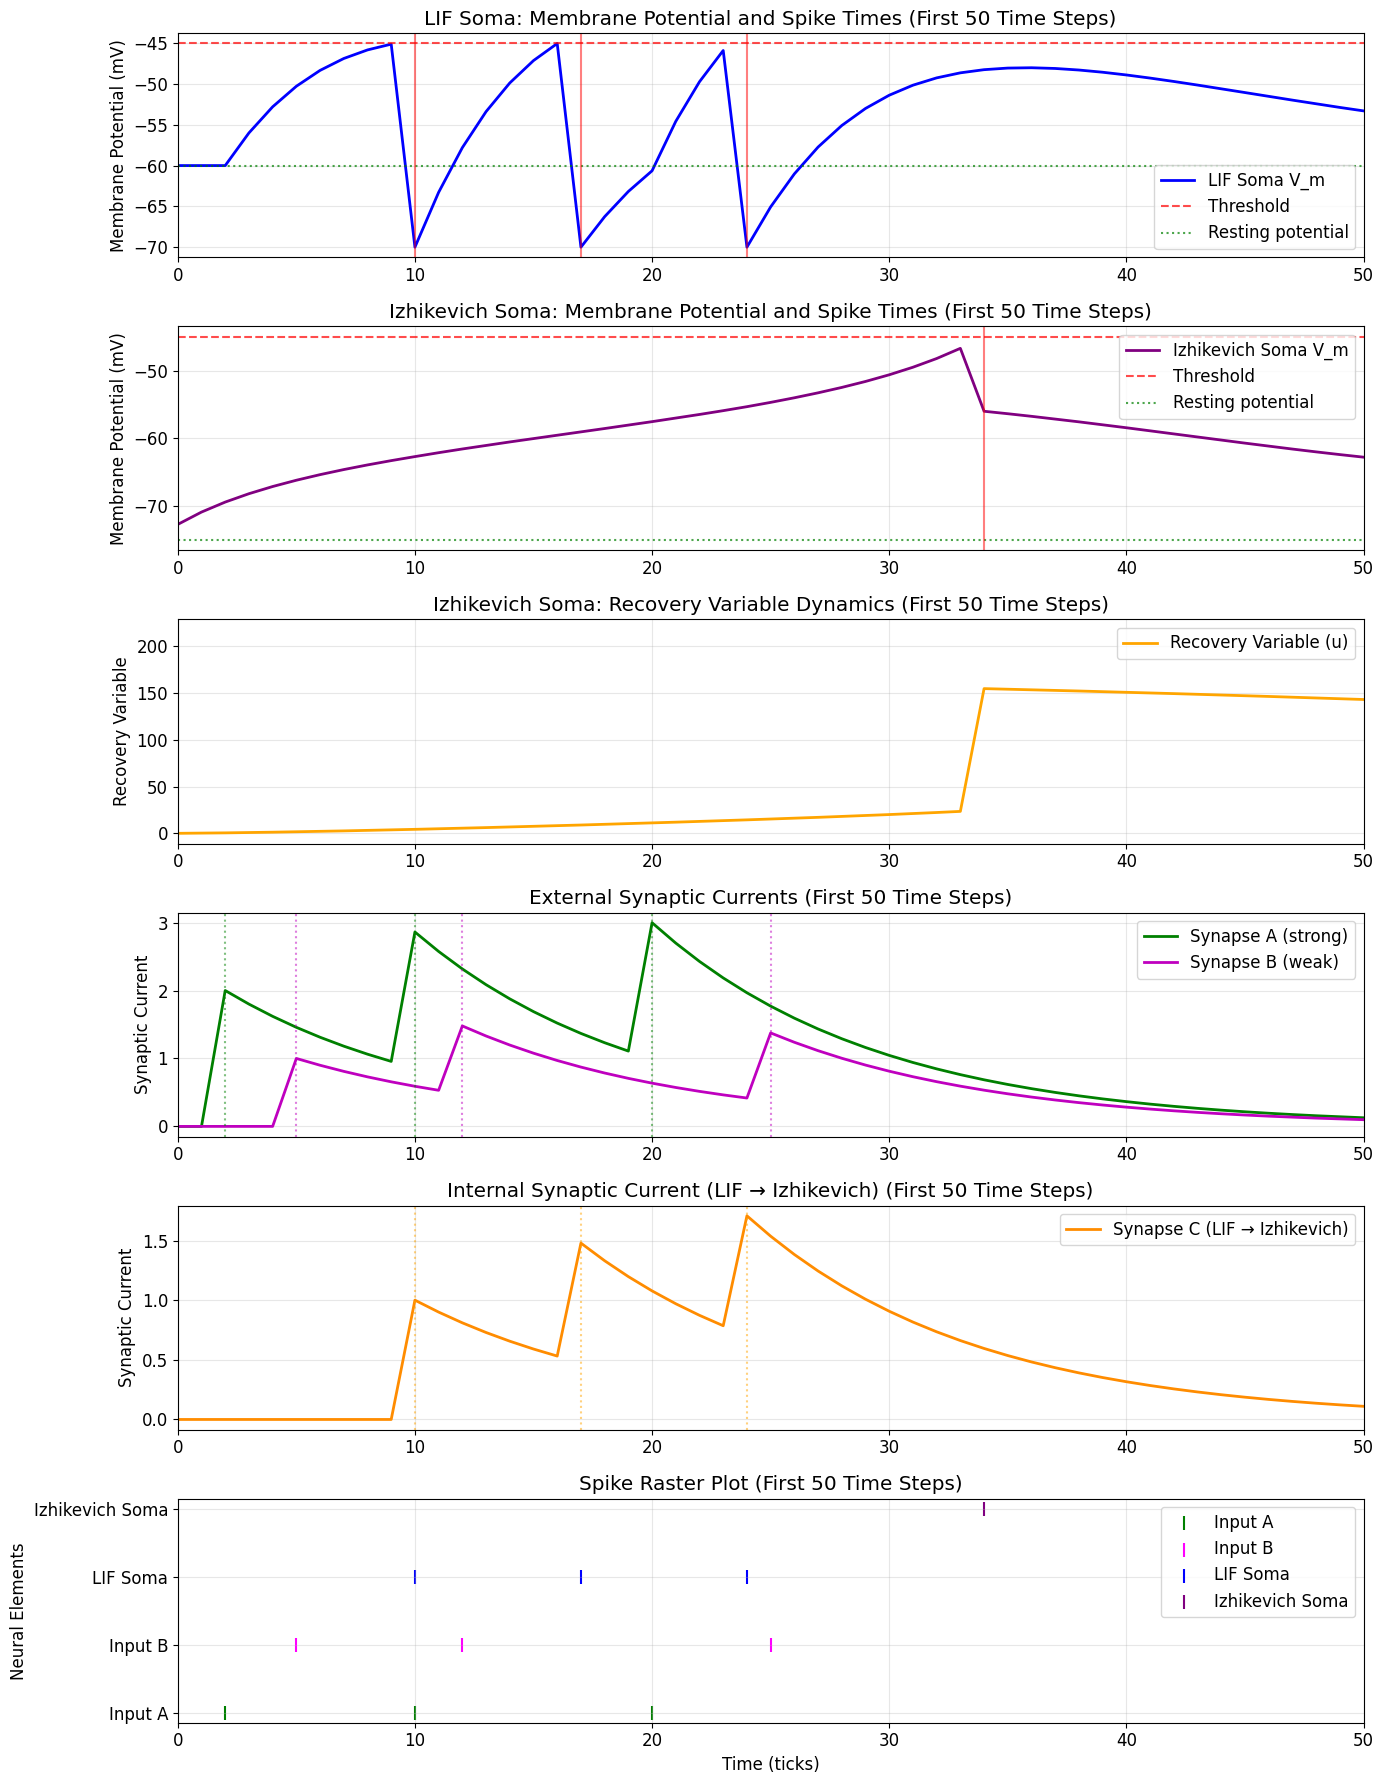

In [54]:
def create_heterogeneous_visualization(results, time_window=50):
    """
    Create comprehensive visualization of the heterogeneous network simulation results.
    
    Args:
        results: Dictionary containing simulation results
        time_window: Number of time steps to display (default: 50)
    """
    # Create figure with subplots
    fig, axes = plt.subplots(6, 1, figsize=(14, 18))
    
    # Time vector
    time_ticks = np.arange(results['simulation_ticks'])
    
    # Plot 1: LIF Soma membrane potential
    ax1 = axes[0]
    ax1.plot(time_ticks, results['lif_soma_states'][:, 0], 'b-', linewidth=2, label='LIF Soma V_m')
    ax1.axhline(y=-45, color='r', linestyle='--', alpha=0.7, label='Threshold')
    ax1.axhline(y=-60, color='g', linestyle=':', alpha=0.7, label='Resting potential')
    
    # Mark spike times
    for spike_time in results['lif_soma_spikes']:
        if spike_time <= time_window:  # Only show spikes within time window
            ax1.axvline(x=spike_time, color='r', alpha=0.5, linestyle='-')
    
    ax1.set_ylabel('Membrane Potential (mV)')
    ax1.set_title(f'LIF Soma: Membrane Potential and Spike Times (First {time_window} Time Steps)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, time_window)
    
    # Plot 2: Izhikevich Soma membrane potential
    ax2 = axes[1]
    ax2.plot(time_ticks, results['izh_soma_states'][:, 0], 'purple', linewidth=2, label='Izhikevich Soma V_m')
    ax2.axhline(y=-45, color='r', linestyle='--', alpha=0.7, label='Threshold')
    ax2.axhline(y=-75, color='g', linestyle=':', alpha=0.7, label='Resting potential')
    
    # Mark spike times
    for spike_time in results['izh_soma_spikes']:
        if spike_time <= time_window:  # Only show spikes within time window
            ax2.axvline(x=spike_time, color='r', alpha=0.5, linestyle='-')
    
    ax2.set_ylabel('Membrane Potential (mV)')
    ax2.set_title(f'Izhikevich Soma: Membrane Potential and Spike Times (First {time_window} Time Steps)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, time_window)
    
    # Plot 3: Izhikevich Recovery Variable
    ax3 = axes[2]
    ax3.plot(time_ticks, results['izh_soma_states'][:, 1], 'orange', linewidth=2, label='Recovery Variable (u)')
    ax3.set_ylabel('Recovery Variable')
    ax3.set_title(f'Izhikevich Soma: Recovery Variable Dynamics (First {time_window} Time Steps)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(0, time_window)
    
    # Plot 4: External synaptic currents A and B
    ax4 = axes[3]
    ax4.plot(time_ticks, results['synapse_A_states'][:, 0], 'g-', linewidth=2, label='Synapse A (strong)')
    ax4.plot(time_ticks, results['synapse_B_states'][:, 0], 'm-', linewidth=2, label='Synapse B (weak)')
    
    # Mark input spike times
    for spike_time, _ in results['spikes_A']:
        if spike_time <= time_window:  # Only show spikes within time window
            ax4.axvline(x=spike_time, color='g', alpha=0.5, linestyle=':')
    for spike_time, _ in results['spikes_B']:
        if spike_time <= time_window:  # Only show spikes within time window
            ax4.axvline(x=spike_time, color='m', alpha=0.5, linestyle=':')
    
    ax4.set_ylabel('Synaptic Current')
    ax4.set_title(f'External Synaptic Currents (First {time_window} Time Steps)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(0, time_window)
    
    # Plot 5: Internal synaptic current C
    ax5 = axes[4]
    ax5.plot(time_ticks, results['synapse_C_states'][:, 0], 'darkorange', linewidth=2, label='Synapse C (LIF → Izhikevich)')
    
    # Mark LIF spike times (which drive synapse C)
    for spike_time in results['lif_soma_spikes']:
        if spike_time <= time_window:  # Only show spikes within time window
            ax5.axvline(x=spike_time, color='orange', alpha=0.5, linestyle=':')
    
    ax5.set_ylabel('Synaptic Current')
    ax5.set_title(f'Internal Synaptic Current (LIF → Izhikevich) (First {time_window} Time Steps)')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    ax5.set_xlim(0, time_window)
    
    # Plot 6: Raster plot of all spikes
    ax6 = axes[5]
    
    # Input spikes
    input_A_times = [spike[0] for spike in results['spikes_A']]
    input_B_times = [spike[0] for spike in results['spikes_B']]
    
    ax6.scatter(input_A_times, [0] * len(input_A_times), c='green', s=100, marker='|', label='Input A')
    ax6.scatter(input_B_times, [0.5] * len(input_B_times), c='magenta', s=100, marker='|', label='Input B')
    
    # Output spikes (limit to time window for visibility)
    lif_spikes_early = [s for s in results['lif_soma_spikes'] if s <= time_window]
    izh_spikes_early = [s for s in results['izh_soma_spikes'] if s <= time_window]
    
    ax6.scatter(lif_spikes_early, [1] * len(lif_spikes_early), c='blue', s=100, marker='|', label='LIF Soma')
    ax6.scatter(izh_spikes_early, [1.5] * len(izh_spikes_early), c='purple', s=100, marker='|', label='Izhikevich Soma')
    
    ax6.set_xlabel('Time (ticks)')
    ax6.set_ylabel('Neural Elements')
    ax6.set_title(f'Spike Raster Plot (First {time_window} Time Steps)')
    ax6.set_yticks([0, 0.5, 1, 1.5])
    ax6.set_yticklabels(['Input A', 'Input B', 'LIF Soma', 'Izhikevich Soma'])
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    ax6.set_xlim(0, time_window)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create comprehensive visualization with default time window
print("Creating visualization with default time window (50 time steps)...")
fig = create_heterogeneous_visualization(results, time_window=50)

# # Example of how to use different time windows
# print(f"\nYou can easily change the time window by calling:")
# print(f"fig = create_heterogeneous_visualization(results, time_window=100)  # Show first 100 time steps")
# print(f"fig = create_heterogeneous_visualization(results, time_window=25)   # Show first 25 time steps")
# print(f"fig = create_heterogeneous_visualization(results, time_window=200)  # Show first 200 time steps")

### Understanding the Heterogeneous Network Results

The visualization reveals several key aspects of the heterogeneous network behavior:

1. **Input Integration**: The LIF soma receives inputs from both Synapse A (strong) and Synapse B (weak). The membrane potential shows how these inputs are integrated over time.

2. **LIF vs Izhikevich Dynamics**: 
   - **LIF neuron**: Shows simple threshold-crossing behavior with immediate reset
   - **Izhikevich neuron**: Exhibits more complex dynamics with the recovery variable (u) creating realistic spike patterns

3. **Synaptic Dynamics**: The exponential decay of synaptic currents is clearly visible. Synapse A produces larger currents due to its higher weight (2.0 vs 1.0).

4. **Spike Propagation**: When the LIF soma fires, it activates Synapse C, which then influences the Izhikevich soma's membrane potential with a synaptic delay.

5. **Recovery Variable**: The Izhikevich neuron's recovery variable (u) shows how it modulates the neuron's excitability and creates adaptation effects.

6. **Heterogeneous Coupling**: The network demonstrates how different neuron types can be coupled together, with the LIF neuron's simple dynamics driving the more complex Izhikevich neuron.

### Key Differences Between Neuron Types:

- **LIF Neuron**: Simple, computationally efficient, uniform spike responses
- **Izhikevich Neuron**: More biologically realistic, complex spike patterns, adaptation mechanisms

### SAGESim Framework Benefits:

This simulation demonstrates how SAGESim enables:
- **Heterogeneous agent types** running in the same simulation
- **Parallel execution** of different neuron models
- **Flexible connectivity** between different agent types
- **Scalable architecture** for large networks with mixed neuron types

## Additional Visualizations

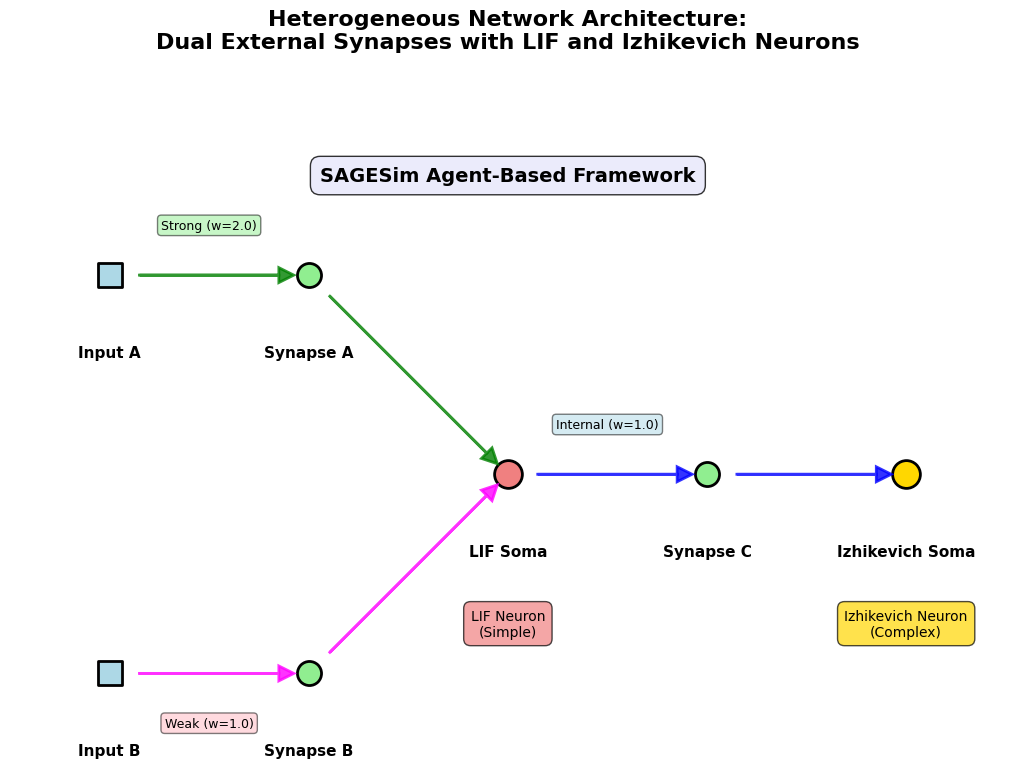

In [50]:
def create_heterogeneous_network_diagram():
    """
    Create a network diagram showing the heterogeneous connectivity.
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Define positions
    positions = {
        'Input A': (0, 2),
        'Input B': (0, -2),
        'Synapse A': (2, 2),
        'Synapse B': (2, -2),
        'LIF Soma': (4, 0),
        'Synapse C': (6, 0),
        'Izhikevich Soma': (8, 0)
    }
    
    # Colors for different types
    colors = {
        'Input A': 'lightblue',
        'Input B': 'lightblue',
        'Synapse A': 'lightgreen',
        'Synapse B': 'lightgreen',
        'LIF Soma': 'lightcoral',
        'Synapse C': 'lightgreen',
        'Izhikevich Soma': 'gold'
    }
    
    # Draw nodes
    for name, (x, y) in positions.items():
        if 'Input' in name:
            ax.scatter(x, y, s=300, c=colors[name], marker='s', edgecolors='black', linewidths=2)
        elif 'Synapse' in name:
            ax.scatter(x, y, s=300, c=colors[name], marker='o', edgecolors='black', linewidths=2)
        elif 'LIF' in name:
            ax.scatter(x, y, s=400, c=colors[name], marker='o', edgecolors='black', linewidths=2)
        else:  # Izhikevich
            ax.scatter(x, y, s=400, c=colors[name], marker='o', edgecolors='black', linewidths=2)
        
        ax.text(x, y-0.7, name, ha='center', va='top', fontsize=11, fontweight='bold')
    
    # Draw connections with different styles
    connections = [
        ('Input A', 'Synapse A', 'green'),
        ('Input B', 'Synapse B', 'magenta'),
        ('Synapse A', 'LIF Soma', 'green'),
        ('Synapse B', 'LIF Soma', 'magenta'),
        ('LIF Soma', 'Synapse C', 'blue'),
        ('Synapse C', 'Izhikevich Soma', 'blue')
    ]
    
    for start, end, color in connections:
        x1, y1 = positions[start]
        x2, y2 = positions[end]
        
        # Calculate arrow position
        dx = x2 - x1
        dy = y2 - y1
        length = np.sqrt(dx**2 + dy**2)
        dx_norm = dx / length
        dy_norm = dy / length
        
        # Start arrow from edge of node
        x1_arrow = x1 + 0.3 * dx_norm
        y1_arrow = y1 + 0.3 * dy_norm
        
        # End arrow at edge of node
        x2_arrow = x2 - 0.3 * dx_norm
        y2_arrow = y2 - 0.3 * dy_norm
        
        ax.arrow(x1_arrow, y1_arrow, x2_arrow - x1_arrow, y2_arrow - y1_arrow,
                head_width=0.15, head_length=0.15, fc=color, ec=color, alpha=0.8, linewidth=2)
    
    # Add labels for connection strengths
    ax.text(1, 2.5, 'Strong (w=2.0)', ha='center', va='center', fontsize=9, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.5))
    ax.text(1, -2.5, 'Weak (w=1.0)', ha='center', va='center', fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightpink', alpha=0.5))
    ax.text(5, 0.5, 'Internal (w=1.0)', ha='center', va='center', fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.5))
    
    # Add neuron type labels
    ax.text(4, -1.5, 'LIF Neuron\n(Simple)', ha='center', va='center', fontsize=10,
            bbox=dict(boxstyle="round,pad=0.5", facecolor='lightcoral', alpha=0.7))
    ax.text(8, -1.5, 'Izhikevich Neuron\n(Complex)', ha='center', va='center', fontsize=10,
            bbox=dict(boxstyle="round,pad=0.5", facecolor='gold', alpha=0.7))
    
    # Add SAGESim framework label
    ax.text(4, 3, 'SAGESim Agent-Based Framework', ha='center', va='center', fontsize=14,
            bbox=dict(boxstyle="round,pad=0.5", facecolor='lavender', alpha=0.8), fontweight='bold')
    
    ax.set_xlim(-1, 9)
    ax.set_ylim(-3, 4)
    ax.set_aspect('equal')
    ax.set_title('Heterogeneous Network Architecture:\nDual External Synapses with LIF and Izhikevich Neurons', 
                fontsize=16, fontweight='bold', pad=20)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create heterogeneous network diagram
hetero_network_fig = create_heterogeneous_network_diagram()

## Summary and Key Takeaways

This tutorial demonstrated how to use SuperNeuroABM to create and simulate heterogeneous spiking neural networks:

### Key Concepts Covered:

1. **Multiple Neuron Types**: Implementation of both LIF and Izhikevich neuron models
2. **Heterogeneous Networks**: Connecting different neuron types in the same simulation
3. **Synaptic Models**: Exponential synapses with different weights and time constants
4. **Network Construction**: Creating complex topologies with mixed neuron types
5. **Simulation**: Running time-stepped simulations with external inputs
6. **Analysis**: Extracting and interpreting results from heterogeneous networks
7. **Visualization**: Creating comprehensive plots to understand network behavior

### SuperNeuroABM Features Demonstrated:

- **Flexible Architecture**: Easy to create heterogeneous network topologies
- **Multiple Neuron Types**: LIF and Izhikevich neurons running in the same simulation
- **Synaptic Dynamics**: Exponential decay with configurable parameters
- **Comprehensive Monitoring**: Track all internal states and spike trains
- **Agent-Based Design**: Built on SAGESim for scalable simulations

### SAGESim Integration Benefits:

1. **Agent-Based Architecture**: 
   - Neurons and synapses are independent agents
   - Each agent maintains its own internal state
   - Parallel execution of all agents

2. **Scalability**:
   - Efficient memory management for large networks
   - GPU acceleration support for massive simulations
   - Modular design for easy network expansion

3. **Flexibility**:
   - Easy to add new neuron types
   - Customizable step functions
   - Heterogeneous agent types in single simulation

4. **Performance**:
   - Optimized for parallel processing
   - Efficient spike communication system
   - Minimal overhead for large-scale simulations

### Key Differences: LIF vs Izhikevich

| Feature | LIF Neuron | Izhikevich Neuron |
|---------|------------|-------------------|
| **Complexity** | Simple | Complex |
| **Variables** | 1 (voltage) | 2 (voltage + recovery) |
| **Dynamics** | Linear integration | Nonlinear dynamics |
| **Realism** | Basic | Biologically realistic |
| **Computation** | Fast | Moderate |
| **Patterns** | Uniform spikes | Diverse spike patterns |

### Next Steps:

1. **Experiment with Parameters**: Try different neuron and synapse parameters
2. **Add More Neuron Types**: Explore other neuron models
3. **Implement Learning**: Add synaptic plasticity mechanisms (STDP)
4. **Scale Up Networks**: Create larger heterogeneous networks
5. **GPU Acceleration**: Run simulations on GPU for better performance
6. **Custom Models**: Develop your own neuron and synapse step functions

This framework provides a powerful foundation for exploring heterogeneous spiking neural network dynamics and developing advanced neuromorphic computing applications.

In [51]:
# Save simulation data for further analysis
def save_heterogeneous_simulation_data(results, filename='tutorial_simulation_data.csv'):
    """
    Save heterogeneous simulation data to CSV file for further analysis.
    
    Args:
        results: Dictionary containing simulation results
        filename: Output filename
    """
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        
        # Write header
        writer.writerow([
            'Time_Tick',
            'LIF_Soma_Membrane_Potential',
            'LIF_Soma_Time_Count',
            'LIF_Soma_Last_Spike_Time',
            'LIF_Soma_Synapse_Current',
            'IZH_Soma_Membrane_Potential',
            'IZH_Soma_Recovery_Variable',
            'Synapse_A_Current',
            'Synapse_B_Current',
            'Synapse_C_Current'
        ])
        
        # Write data
        for i in range(results['simulation_ticks']):
            writer.writerow([
                i,
                results['lif_soma_states'][i, 0],  # LIF membrane potential
                results['lif_soma_states'][i, 1],  # LIF time count
                results['lif_soma_states'][i, 2],  # LIF last spike time
                results['lif_soma_states'][i, 3],  # LIF synaptic current
                results['izh_soma_states'][i, 0],  # Izhikevich membrane potential
                results['izh_soma_states'][i, 1],  # Izhikevich recovery variable
                results['synapse_A_states'][i, 0], # Synapse A current
                results['synapse_B_states'][i, 0], # Synapse B current
                results['synapse_C_states'][i, 0]  # Synapse C current
            ])
    
    print(f"Heterogeneous simulation data saved to {filename}")
    print(f"Data includes:")
    print(f"  - LIF soma: membrane potential, time count, last spike time, synaptic current")
    print(f"  - Izhikevich soma: membrane potential, recovery variable")
    print(f"  - All synapses: synaptic currents")
    
    # Also save spike times separately
    spike_filename = filename.replace('.csv', '_spikes.csv')
    with open(spike_filename, 'w', newline='') as spike_file:
        spike_writer = csv.writer(spike_file)
        spike_writer.writerow(['Neuron_Type', 'Spike_Time'])
        
        # Write LIF spikes
        for spike_time in results['lif_soma_spikes']:
            spike_writer.writerow(['LIF', spike_time])
        
        # Write Izhikevich spikes
        for spike_time in results['izh_soma_spikes']:
            spike_writer.writerow(['Izhikevich', spike_time])
    
    print(f"Spike times saved to {spike_filename}")

# Save the heterogeneous simulation data
save_heterogeneous_simulation_data(results)

# Display summary statistics
print(f"\nSimulation Summary:")
print(f"  Duration: {results['simulation_ticks']} time steps")
print(f"  LIF soma spikes: {len(results['lif_soma_spikes'])}")
print(f"  Izhikevich soma spikes: {len(results['izh_soma_spikes'])}")
print(f"  Total network spikes: {len(results['lif_soma_spikes']) + len(results['izh_soma_spikes'])}")
print(f"  Input spikes: {len(results['spikes_A']) + len(results['spikes_B'])}")
print(f"  Network amplification: {(len(results['lif_soma_spikes']) + len(results['izh_soma_spikes']))/(len(results['spikes_A']) + len(results['spikes_B'])):.2f}x")

Heterogeneous simulation data saved to tutorial_simulation_data.csv
Data includes:
  - LIF soma: membrane potential, time count, last spike time, synaptic current
  - Izhikevich soma: membrane potential, recovery variable
  - All synapses: synaptic currents
Spike times saved to tutorial_simulation_data_spikes.csv

Simulation Summary:
  Duration: 600 time steps
  LIF soma spikes: 3
  Izhikevich soma spikes: 2
  Total network spikes: 5
  Input spikes: 6
  Network amplification: 0.83x
